# 参考答案

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 第一章 预备知识

### Ex1：利用列表推导式写矩阵乘法

In [2]:
M1 = np.random.rand(2,3)
M2 = np.random.rand(3,4)
res = [[sum([M1[i][k] * M2[k][j] for k in range(M1.shape[1])]) for j in range(M2.shape[1])] for i in range(M1.shape[0])]
(np.abs((M1@M2 - res) < 1e-15)).all()

True

### Ex2：更新矩阵

In [3]:
A = np.arange(1,10).reshape(3,-1)
B = A*(1/A).sum(1).reshape(-1,1)
B

array([[1.83333333, 3.66666667, 5.5       ],
       [2.46666667, 3.08333333, 3.7       ],
       [2.65277778, 3.03174603, 3.41071429]])

### Ex3：卡方统计量

In [4]:
np.random.seed(0)
A = np.random.randint(10, 20, (8, 5))
B = A.sum(0)*A.sum(1).reshape(-1, 1)/A.sum()
res = ((A-B)**2/B).sum()
res

11.842696601945802

### Ex4：改进矩阵计算的性能

原方法：

In [5]:
np.random.seed(0)
m, n, p = 100, 80, 50
B = np.random.randint(0, 2, (m, p))
U = np.random.randint(0, 2, (p, n))
Z = np.random.randint(0, 2, (m, n))
def solution(B=B, U=U, Z=Z):
    L_res = []
    for i in range(m):
        for j in range(n):
            norm_value = ((B[i]-U[:,j])**2).sum()
            L_res.append(norm_value*Z[i][j])
    return sum(L_res)
solution(B, U, Z)

100566

改进方法：

令$Y_{ij} = \|B_i-U_j\|_2^2$，则$\displaystyle R=\sum_{i=1}^m\sum_{j=1}^n Y_{ij}Z_{ij}$，这在`Numpy`中可以用逐元素的乘法后求和实现，因此问题转化为了如何构造`Y`矩阵。

$$
\begin{split}Y_{ij} &= \|B_i-U_j\|_2^2\\
&=\sum_{k=1}^p(B_{ik}-U_{kj})^2\\
&=\sum_{k=1}^p B_{ik}^2+\sum_{k=1}^p U_{kj}^2-2\sum_{k=1}^p B_{ik}U_{kj}\\\end{split}
$$

从上式可以看出，第一第二项分别为$B$的行平方和与$U$的列平方和，第三项是两倍的内积。因此，$Y$矩阵可以写为三个部分，第一个部分是$m×n$的全$1$矩阵每行乘以$B$对应行的行平方和，第二个部分是相同大小的全$1$矩阵每列乘以$U$对应列的列平方和，第三个部分恰为$B$矩阵与$U$矩阵乘积的两倍。从而结果如下：

In [6]:
(((B**2).sum(1).reshape(-1,1) + (U**2).sum(0) - 2*B@U)*Z).sum()

100566

对比它们的性能：

In [7]:
%timeit -n 30 solution(B, U, Z)

25.9 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [8]:
%timeit -n 30 ((np.ones((m,n))*(B**2).sum(1).reshape(-1,1) + np.ones((m,n))*(U**2).sum(0) - 2*B@U)*Z).sum()

1.85 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


### Ex5：连续整数的最大长度

In [9]:
f = lambda x:np.diff(np.nonzero(np.r_[1,np.diff(x)!=1,1])).max()
f([1,2,5,6,7])
f([3,2,1,2,3,4,6])

4

## 第二章 pandas基础
### Ex1：口袋妖怪数据集
#### 1.

In [10]:
df = pd.read_csv('../data/pokemon.csv')
(df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].sum(1)!=df['Total']).mean()

0.0

#### 2.
(a)

In [11]:
dp_dup = df.drop_duplicates('#', keep='first')
dp_dup['Type 1'].nunique()
dp_dup['Type 1'].value_counts().index[:3]

Index(['Water', 'Normal', 'Grass'], dtype='object', name='Type 1')

(b)

In [12]:
attr_dup = dp_dup.drop_duplicates(['Type 1', 'Type 2'])
attr_dup.shape[0]

143

(c)

In [13]:
L_full = [i+' '+j if i!=j else i for i in df['Type 1'].unique() for j in df['Type 1'].unique()]
L_part = [i+' '+j if not isinstance(j, float) else i for i, j in zip(df['Type 1'], df['Type 2'])]
res = set(L_full).difference(set(L_part))
len(res) # 太多，不打印了

170

#### 3.
(a)

In [14]:
df['Attack'].mask(df['Attack']>120, 'high').mask(df['Attack']<50, 'low').mask((50<=df['Attack'])&(df['Attack']<=120), 'mid').head()

0    low
1    mid
2    mid
3    mid
4    mid
Name: Attack, dtype: object

(b)

In [15]:
df['Type 1'].replace({i:str.upper(i) for i in df['Type 1'].unique()})
df['Type 1'].apply(lambda x:str.upper(x)).head()

0    GRASS
1    GRASS
2    GRASS
3    GRASS
4     FIRE
Name: Type 1, dtype: object

(c)

In [16]:
df['Deviation'] = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].apply(lambda x:np.max((x-x.median()).abs()), 1)
df.sort_values('Deviation', ascending=False).head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Deviation
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,215.0
121,113,Chansey,Normal,NaN,450,250,5,5,35,105,50,207.5
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,190.0
333,306,AggronMega Aggron,Steel,NaN,630,70,140,230,60,80,50,155.0
224,208,SteelixMega Steelix,Steel,Ground,610,75,125,230,55,95,30,145.0


### Ex2：指数加权窗口
#### 1.

In [17]:
np.random.seed(0)
s = pd.Series(np.random.randint(-1,2,30).cumsum())
s.ewm(alpha=0.2).mean().head()
def ewm_func(x, alpha=0.2):
    win = (1-alpha)**np.arange(x.shape[0])[::-1]
    res = (win*x).sum()/win.sum()
    return res
s.expanding().apply(ewm_func).head()

0   -1.000000
1   -1.000000
2   -1.409836
3   -1.609756
4   -1.725845
dtype: float64

#### 2.

新的权重为$w_i = (1 - \alpha)^i, i\in \{0,1,...,n-1\}$，$y_t$更新如下：
$$
\begin{split}y_t &=\frac{\sum_{i=0}^{n-1} w_i x_{t-i}}{\sum_{i=0}^{n-1} w_i} \\
&=\frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^{n-1} x_{t-(n-1)}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^{n-1}}\\\end{split}
$$


In [18]:
s.rolling(window=4).apply(ewm_func).head() # 无需对原函数改动

0         NaN
1         NaN
2         NaN
3   -1.609756
4   -1.826558
dtype: float64

## 第三章 索引
### Ex1：公司员工数据集
#### 1.

In [19]:
df = pd.read_csv('../data/company.csv')
dpt = ['Dairy', 'Bakery']
df.query("(age <= 40)&(department == @dpt)&(gender=='M')").head(3)

,EmployeeID,birthdate_key,age,city_name,department,job_title,gender
3611,5791,1/14/1975,40,Kelowna,Dairy,Dairy Person,M
3613,5793,1/22/1975,40,Richmond,Bakery,Baker,M
3615,5795,1/30/1975,40,Nanaimo,Dairy,Dairy Person,M


In [20]:
df.loc[(df.age<=40)&df.department.isin(dpt)&(df.gender=='M')].head(3)

,EmployeeID,birthdate_key,age,city_name,department,job_title,gender
3611,5791,1/14/1975,40,Kelowna,Dairy,Dairy Person,M
3613,5793,1/22/1975,40,Richmond,Bakery,Baker,M
3615,5795,1/30/1975,40,Nanaimo,Dairy,Dairy Person,M


#### 2.

In [21]:
df.iloc[(df.EmployeeID%2==1).values,[0,2,-2]].head()

,EmployeeID,age,job_title
1,1319,58,VP Stores
3,1321,56,VP Human Resources
5,1323,53,"Exec Assistant, VP Stores"
6,1325,51,"Exec Assistant, Legal Counsel"
8,1329,48,Store Manager


#### 3.

In [22]:
df_op = df.copy()
df_op = df_op.set_index(df_op.columns[-3:].tolist()).swaplevel(0,2,axis=0)
df_op = df_op.reset_index(level=1)
df_op = df_op.rename_axis(index={'gender':'Gender'})
df_op.index = df_op.index.map(lambda x:'_'.join(x))
df_op.index = df_op.index.map(lambda x:tuple(x.split('_')))
df_op = df_op.rename_axis(index=['gender', 'department'])
df_op = df_op.reset_index().reindex(df.columns, axis=1)
df_op.equals(df)

True

### Ex2：巧克力数据集
#### 1.

In [23]:
df = pd.read_csv('../data/chocolate.csv')
df.columns = [' '.join(i.split('\n')) for i in df.columns]
df.head(3)

,Company,Review Date,Cocoa Percent,Company Location,Rating
0,A. Morin,2016,63%,France,3.75
1,A. Morin,2015,70%,France,2.75
2,A. Morin,2015,70%,France,3.00


#### 2.

In [24]:
df["Cocoa Percent"] = df["Cocoa Percent"].apply(lambda x:float(x[:-1])/100)
df.query('(Rating<3)&(`Cocoa Percent`>`Cocoa Percent`.median())').head(3)

,Company,Review Date,Cocoa Percent,Company Location,Rating
33,Akesson's (Pralus),2010,0.75,Switzerland,2.75
34,Akesson's (Pralus),2010,0.75,Switzerland,2.75
36,Alain Ducasse,2014,0.75,France,2.75


#### 3.

In [25]:
idx = pd.IndexSlice
exclude = ['France', 'Canada', 'Amsterdam', 'Belgium']
res = df.set_index(['Review Date', 'Company Location']).sort_index(level=0)
res.loc[idx[2012:,~res.index.get_level_values(1).isin(exclude)],:].head(3)

Company  Cocoa Percent  Rating
Review Date Company Location                                    
2012        Australia         Bahen & Co.            0.7     3.0
            Australia         Bahen & Co.            0.7     2.5
            Australia         Bahen & Co.            0.7     2.5

## 第四章 分组
### Ex1：汽车数据集
#### 1.

In [26]:
df = pd.read_csv('../data/car.csv')
df.groupby('Country').filter(lambda x:x.shape[0]>2).groupby('Country')['Price'].agg([('CoV', lambda x: x.std()/x.mean()), 'mean', 'count'])

,CoV,mean,count
Country,,,
Japan,0.387429,13938.052632,19
Japan/USA,0.240040,10067.571429,7
Korea,0.243435,7857.333333,3
USA,0.203344,12543.269231,26


#### 2.

In [27]:
df.shape[0]

60

In [28]:
condition = ['Head']*20+['Mid']*20+['Tail']*20
df.groupby(condition)['Price'].mean()

Head     9069.95
Mid     13356.40
Tail    15420.65
Name: Price, dtype: float64

#### 3.

In [29]:
res = df.groupby('Type').agg({'Price': ['max'], 'HP': ['min']})
res.columns = res.columns.map(lambda x:'_'.join(x))
res

,Price_max,HP_min
Type,,
Compact,18900,95
Large,17257,150
Medium,24760,110
Small,9995,63
Sporty,13945,92
Van,15395,106


#### 4.

In [30]:
def normalize(s):
    s_min, s_max = s.min(), s.max()
    res = (s - s_min)/(s_max - s_min)
    return res
df.groupby('Type')['HP'].transform(normalize).head()

0    1.00
1    0.54
2    0.00
3    0.58
4    0.80
Name: HP, dtype: float64

#### 5.

In [31]:
df.groupby('Type')[['HP', 'Disp.']].apply(lambda x:np.corrcoef(x['HP'].values, x['Disp.'].values)[0,1])

Type
Compact    0.586087
Large     -0.242765
Medium     0.370491
Small      0.603916
Sporty     0.871426
Van        0.819881
dtype: float64

### Ex2：实现transform函数

In [32]:
class my_groupby:
    def __init__(self, my_df, group_cols):
        self.my_df = my_df.copy()
        self.groups = my_df[group_cols].drop_duplicates()
        if isinstance(self.groups, pd.Series):
            self.groups = self.groups.to_frame()
        self.group_cols = self.groups.columns.tolist()
        self.groups = {i: self.groups[i].values.tolist() for i in self.groups.columns}
        self.transform_col = None
    def __getitem__(self, col):
        self.pr_col = [col] if isinstance(col, str) else list(col)
        return self
    def transform(self, my_func):
        self.num = len(self.groups[self.group_cols[0]])
        L_order, L_value = np.array([]), np.array([])
        for i in range(self.num):
            group_df = self.my_df.reset_index().copy()
            for col in self.group_cols:
                group_df = group_df[group_df[col]==self.groups[col][i]]
            group_df = group_df[self.pr_col]
            if group_df.shape[1] == 1:
                group_df = group_df.iloc[:, 0]
            group_res = my_func(group_df)
            if not isinstance(group_res, pd.Series):
                group_res = pd.Series(group_res,index=group_df.index,name=group_df.name)
            L_order = np.r_[L_order, group_res.index]
            L_value = np.r_[L_value, group_res.values]
        self.res = pd.Series(pd.Series(L_value, index=L_order).sort_index().values,index=self.my_df.reset_index().index, name=my_func.__name__)
        return self.res

my_groupby(df, 'Type')

单列分组：

In [33]:
def f(s):
    res = (s-s.min())/(s.max()-s.min())
    return res
my_groupby(df, 'Type')['Price'].transform(f).head()

0    0.733592
1    0.372003
2    0.109712
3    0.186244
4    0.177525
Name: f, dtype: float64

In [34]:
df.groupby('Type')['Price'].transform(f).head()

0    0.733592
1    0.372003
2    0.109712
3    0.186244
4    0.177525
Name: Price, dtype: float64

多列分组：

In [35]:
my_groupby(df, ['Type','Country'])['Price'].transform(f).head()

0    1.000000
1    0.000000
2    0.000000
3    0.000000
4    0.196357
Name: f, dtype: float64

In [36]:
df.groupby(['Type','Country'])['Price'].transform(f).head()

0    1.000000
1    0.000000
2    0.000000
3    0.000000
4    0.196357
Name: Price, dtype: float64

标量广播：

In [37]:
my_groupby(df, 'Type')['Price'].transform(lambda x:x.mean()).head()

0    7682.384615
1    7682.384615
2    7682.384615
3    7682.384615
4    7682.384615
Name: <lambda>, dtype: float64

In [38]:
df.groupby('Type')['Price'].transform(lambda x:x.mean()).head()

0    7682.384615
1    7682.384615
2    7682.384615
3    7682.384615
4    7682.384615
Name: Price, dtype: float64

跨列计算：

In [39]:
my_groupby(df, 'Type')['Disp.', 'HP'].transform(lambda x: x['Disp.']/x.HP).head()

0    0.858407
1    1.266667
2    1.285714
3    0.989130
4    1.097087
Name: <lambda>, dtype: float64

## 第五章 变形
### Ex1：美国非法药物数据集
#### 1.

In [40]:
df = pd.read_csv('../data/drugs.csv').sort_values(['State','COUNTY','SubstanceName'],ignore_index=True)
res = df.pivot(index=['State','COUNTY','SubstanceName'], columns='YYYY', values='DrugReports').reset_index().rename_axis(columns={'YYYY':''})
res.head(5)

,State,COUNTY,SubstanceName,2010,2011,2012,2013,2014,2015,2016,2017
0,KY,ADAIR,Buprenorphine,NaN,3.0,5.0,4.0,27.0,5.0,7.0,10.0
1,KY,ADAIR,Codeine,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
2,KY,ADAIR,Fentanyl,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,KY,ADAIR,Heroin,NaN,NaN,1.0,2.0,NaN,1.0,NaN,2.0
4,KY,ADAIR,Hydrocodone,6.0,9.0,10.0,10.0,9.0,7.0,11.0,3.0


#### 2.

In [41]:
res_melted = res.melt(id_vars = ['State','COUNTY','SubstanceName'],
                      value_vars = res.columns[-8:],
                      var_name = 'YYYY',
                      value_name = 'DrugReports').dropna(
                      subset=['DrugReports'])
res_melted = res_melted[df.columns].sort_values(['State','COUNTY','SubstanceName'],ignore_index=True).astype({'YYYY':'int64', 'DrugReports':'int64'})
res_melted.equals(df)

True

#### 3.
策略一：

In [42]:
res = df.pivot_table(index='YYYY', columns='State', values='DrugReports', aggfunc='sum')
res.head(3)

State,KY,OH,PA,VA,WV
YYYY,,,,,
2010,10453,19707,19814,8685,2890
2011,10289,20330,19987,6749,3271
2012,10722,23145,19959,7831,3376


策略二：

In [43]:
res = df.groupby(['State', 'YYYY'])['DrugReports'].sum().to_frame().unstack(0).droplevel(0,axis=1)
res.head(3)

State,KY,OH,PA,VA,WV
YYYY,,,,,
2010,10453,19707,19814,8685,2890
2011,10289,20330,19987,6749,3271
2012,10722,23145,19959,7831,3376


### Ex2：特殊的wide_to_long方法

In [44]:
df = pd.DataFrame({'Class':[1,2],
                   'Name':['San Zhang', 'Si Li'],
                   'Chinese':[80, 90],
                   'Math':[80, 75]})
df

,Class,Name,Chinese,Math
0,1,San Zhang,80,80
1,2,Si Li,90,75


In [45]:
df = df.rename(columns={'Chinese':'pre_Chinese', 'Math':'pre_Math'})
pd.wide_to_long(df,
                stubnames=['pre'],
                i = ['Class', 'Name'],
                j='Subject',
                sep='_',
                suffix='.+').reset_index().rename(columns={'pre':'Grade'})

,Class,Name,Subject,Grade
0,1,San Zhang,Chinese,80
1,1,San Zhang,Math,80
2,2,Si Li,Chinese,90
3,2,Si Li,Math,75


## 第六章 连接
### Ex1：美国疫情数据集

In [46]:
date = pd.date_range('20200412', '20201116').to_series()
date = date.dt.month.astype('string').str.zfill(2) +'-'+ date.dt.day.astype('string').str.zfill(2) +'-'+ '2020'
date = date.tolist()

In [47]:
L = []
for d in date:
    df = pd.read_csv('../data/us_report/' + d + '.csv', index_col='Province_State')
    data = df.loc['New York', ['Confirmed','Deaths','Recovered','Active']]
    L.append(data.to_frame().T)
res = pd.concat(L)
res.index = date
res.head()

,Confirmed,Deaths,Recovered,Active
04-12-2020,189033,9385,23887.0,179648
04-13-2020,195749,10058,23887.0,185691.0
04-14-2020,203020,10842,23887.0,192178.0
04-15-2020,214454,11617,23887.0,202837.0
04-16-2020,223691,14832,23887.0,208859.0


### Ex2：实现join函数

In [48]:
def join(df1, df2, how='left'):
    res_col = df1.columns.tolist() +  df2.columns.tolist()
    dup = df1.index.unique().intersection(df2.index.unique())
    res_df = pd.DataFrame(columns = res_col)
    for label in dup:
        cartesian = [list(i)+list(j) for i in df1.loc[label].values.reshape(-1,1) for j in df2.loc[label].values.reshape(-1,1)]
        dup_df = pd.DataFrame(cartesian, index = [label]*len(cartesian), columns = res_col)
        res_df = pd.concat([res_df,dup_df])
    if how in ['left', 'outer']:
        for label in df1.index.unique().difference(dup):
            if isinstance(df1.loc[label], pd.DataFrame):
                cat = [list(i)+[np.nan]*df2.shape[1] for i in df1.loc[label].values]
            else:
                cat = [list(i)+[np.nan]*df2.shape[1] for i in df1.loc[label].to_frame().values]
            dup_df = pd.DataFrame(cat, index = [label]*len(cat), columns = res_col)
            res_df = pd.concat([res_df,dup_df])
    if how in ['right', 'outer']:
        for label in df2.index.unique().difference(dup):
            if isinstance(df2.loc[label], pd.DataFrame):
                cat = [[np.nan]+list(i)*df1.shape[1] for i in df2.loc[label].values]
            else:
                cat = [[np.nan]+list(i)*df1.shape[1] for i in df2.loc[label].to_frame().values]
            dup_df = pd.DataFrame(cat, index = [label]*len(cat), columns = res_col)
            res_df = pd.concat([res_df,dup_df])
    return res_df

In [49]:
df1 = pd.DataFrame({'col1':[1,2,3,4,5]}, index=list('AABCD'))
df1

,col1
A,1
A,2
B,3
C,4
D,5


In [50]:
df2 = pd.DataFrame({'col2':list('opqrst')}, index=list('ABBCEE'))
df2

,col2
A,o
B,p
B,q
C,r
E,s
E,t


In [51]:
join(df1, df2, how='inner')

,col1,col2
A,1,o
A,2,o
B,3,p
B,3,q
C,4,r


## 第七章 缺失数据
### Ex1：缺失值与类别的相关性检验

In [52]:
df = pd.read_csv('../data/missing_chi.csv')
cat_1 = df.X_1.fillna('NaN').mask(df.X_1.notna()).fillna("NotNaN")
cat_2 = df.X_2.fillna('NaN').mask(df.X_2.notna()).fillna("NotNaN")
df_1 = pd.crosstab(cat_1, df.y, margins=True)
df_2 = pd.crosstab(cat_2, df.y, margins=True)
def compute_S(my_df):
    S = []
    for i in range(2):
        for j in range(2):
            E = my_df.iat[i, j]
            F = my_df.iat[i, 2]*my_df.iat[2, j]/my_df.iat[2,2]
            S.append((E-F)**2/F)
    return sum(S)
res1 = compute_S(df_1)
res2 = compute_S(df_2)
from scipy.stats import chi2
chi2.sf(res1, 1) # X_1检验的p值 # 不能认为相关，剔除

0.9712760884395901

In [53]:
chi2.sf(res2, 1) # X_2检验的p值 # 认为相关，保留

7.459641265637543e-166

结果与`scipy.stats.chi2_contingency`在不使用$Yates$修正的情况下完全一致：

In [54]:
from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(cat_1, df.y), correction=False)[1]
chi2_contingency(pd.crosstab(cat_2, df.y), correction=False)[1]

7.459641265637543e-166

### Ex2：用回归模型解决分类问题
#### 1.

In [55]:
from sklearn.neighbors import KNeighborsRegressor
df = pd.read_excel('../data/color.xlsx')
df_dummies = pd.get_dummies(df.Color)
stack_list = []
for col in df_dummies.columns:
    clf = KNeighborsRegressor(n_neighbors=6)
    clf.fit(df.iloc[:,:2], df_dummies[col])
    res = clf.predict([[0.8, -0.2]]).reshape(-1,1)
    stack_list.append(res)
code_res = pd.Series(np.hstack(stack_list).argmax(1))
df_dummies.columns[code_res[0]]

D:\program\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
D:\program\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
D:\program\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


'Yellow'

## 第八章 文本数据
### Ex1：房屋信息数据集
#### 1.

In [56]:
df = pd.read_excel('../data/house_info.xls', usecols=['floor','year','area','price'])
df.year = pd.to_numeric(df.year.str[:-2]).astype('Int64')
df.head(3)

,floor,year,area,price
0,高层（共6层）,1986,58.23㎡,155万
1,中层（共20层）,2020,88㎡,155万
2,低层（共28层）,2010,89.33㎡,365万


#### 2.

In [58]:
pat = '(\w层)（共(\d+)层）'
new_cols = df.floor.str.extract(pat).rename(columns={0:'Level', 1:'Highest'})
df = pd.concat([df.drop(columns=['floor']), new_cols])
df.head(3)

,year,area,price,Level,Highest
0,1986,58.23㎡,155万,NaN,NaN
1,2020,88㎡,155万,NaN,NaN
2,2010,89.33㎡,365万,NaN,NaN


#### 3.

In [59]:
s_area = pd.to_numeric(df.area.str[:-1])
s_price = pd.to_numeric(df.price.str[:-1])
df['avg_price'] = ((s_price/s_area)*10000).astype('int').astype('string') + '元/平米'
df.head(3)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

### Ex2：《权力的游戏》剧本数据集
#### 1.

In [61]:
df = pd.read_csv('../data/script.csv')
df.columns = df.columns.str.strip()
df.groupby(['Season', 'Episode'])['Sentence'].count().head()

Season    Episode   
Season 1  Episode 1     327
          Episode 10    266
          Episode 2     283
          Episode 3     353
          Episode 4     404
Name: Sentence, dtype: int64

#### 2.

In [62]:
df.set_index('Name').Sentence.str.split().str.len().groupby('Name').mean().sort_values(ascending=False).head()

Name
male singer          109.000000
slave owner           77.000000
manderly              62.000000
lollys stokeworth     62.000000
dothraki matron       56.666667
Name: Sentence, dtype: float64

#### 3.

In [ ]:
s = pd.Series(df.Sentence.values, index=df.Name.shift(-1))
s.str.count('\?').groupby('Name').sum().sort_values(ascending=False).head()

## 第九章 分类数据
### Ex1：统计未出现的类别

In [63]:
def my_crosstab(s1, s2, dropna=True):
    idx1 = (s1.cat.categories if s1.dtype.name == 'category' and not dropna else s1.unique())
    idx2 = (s2.cat.categories if s2.dtype.name == 'category' and not dropna else s2.unique())
    res = pd.DataFrame(np.zeros((idx1.shape[0], idx2.shape[0])), index=idx1, columns=idx2)
    for i, j in zip(s1, s2):
        res.at[i, j] += 1
    res = res.rename_axis(index=s1.name, columns=s2.name).astype('int')
    return res
df = pd.DataFrame({'A':['a','b','c','a'], 'B':['cat','cat','dog','cat']})
df.B = df.B.astype('category').cat.add_categories('sheep')
my_crosstab(df.A, df.B)
my_crosstab(df.A, df.B, dropna=False)

B,cat,dog,sheep
A,,,
a,2,0,0
b,1,0,0
c,0,1,0


### Ex2：钻石数据集
#### 1.

In [64]:
df = pd.read_csv('../data/diamonds.csv')
s_obj, s_cat = df.cut, df.cut.astype('category')

In [65]:
%timeit -n 30 s_obj.nunique()

5.46 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [73]:
%timeit -n 30 s_cat.nunique()

674 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


#### 2.

In [75]:
df.cut = df.cut.astype('category').cat.reorder_categories(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],ordered=True)
df.clarity = df.clarity.astype('category').cat.reorder_categories(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],ordered=True)
res = df.sort_values(['cut', 'clarity'], ascending=[False, True])
res.head(3)

,carat,cut,clarity,price,avg_cut,avg_qcut
315,0.96,Ideal,I1,2801,Low,Low
535,0.96,Ideal,I1,2826,Low,Low
551,0.97,Ideal,I1,2830,Low,Low


In [76]:
res.tail(3)

,carat,cut,clarity,price,avg_cut,avg_qcut
47407,0.52,Fair,IF,1849,Mid,Mid
49683,0.52,Fair,IF,2144,Mid,High
50126,0.47,Fair,IF,2211,Mid,High


#### 4.

In [77]:
q = [0, 0.2, 0.4, 0.6, 0.8, 1]
point = [-np.infty, 1000, 3500, 5500, 18000, np.infty]
avg = df.price / df.carat
df['avg_cut'] = pd.cut(avg, bins=point, labels=['Very Low', 'Low', 'Mid', 'High', 'Very High'])
df['avg_qcut'] = pd.qcut(avg, q=q, labels=['Very Low', 'Low', 'Mid', 'High', 'Very High'])
df.head()

,carat,cut,clarity,price,avg_cut,avg_qcut
0,0.23,Ideal,SI2,326,Low,Very Low
1,0.21,Premium,SI1,326,Low,Very Low
2,0.23,Good,VS1,327,Low,Very Low
3,0.29,Premium,VS2,334,Low,Very Low
4,0.31,Good,SI2,335,Low,Very Low


#### 5.

In [78]:
df.avg_cut.unique()

['Low', 'Mid', 'High']
Categories (5, object): ['Very Low' < 'Low' < 'Mid' < 'High' < 'Very High']

In [80]:
df.avg_cut.cat.categories

Index(['Very Low', 'Low', 'Mid', 'High', 'Very High'], dtype='object')

In [81]:
df.avg_cut = df.avg_cut.cat.remove_categories(['Very Low', 'Very High'])
df.avg_cut.head(3)

0    Low
1    Low
2    Low
Name: avg_cut, dtype: category
Categories (3, object): ['High' < 'Low' < 'Mid']

#### 6.

In [82]:
interval_avg = pd.IntervalIndex(pd.qcut(avg, q=q))
interval_avg.right.to_series().reset_index(drop=True).head(3)

0    2295.0
1    2295.0
2    2295.0
dtype: float64

In [83]:
interval_avg.left.to_series().reset_index(drop=True).head(3)

0    1051.162
1    1051.162
2    1051.162
dtype: float64

In [84]:
interval_avg.length.to_series().reset_index(drop=True).head(3)

0    1243.838
1    1243.838
2    1243.838
dtype: float64

## 第十章 时序数据
### Ex1：太阳辐射数据集
#### 1.

In [85]:
df = pd.read_csv('../data/solar.csv', usecols=['Data','Time','Radiation','Temperature'])
solar_date = df.Data.str.extract('([/|\w]+\s).+')[0]
df['Data'] = pd.to_datetime(solar_date + df.Time)
df = df.drop(columns='Time').rename(columns={'Data':'Datetime'}).set_index('Datetime').sort_index()
df.head(3)

,Radiation,Temperature
Datetime,,
2016-09-01 00:00:08,2.58,51
2016-09-01 00:05:10,2.83,51
2016-09-01 00:20:06,2.16,51


#### 2.
(a)

In [86]:
s = df.index.to_series().reset_index(drop=True).diff().dt.total_seconds()
max_3 = s.nlargest(3).index
df.index[max_3.union(max_3-1)]

DatetimeIndex(['2016-09-29 23:55:26', '2016-10-01 00:00:19',
               '2016-11-29 19:05:02', '2016-12-01 00:00:02',
               '2016-12-05 20:45:53', '2016-12-08 11:10:42'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

(b)

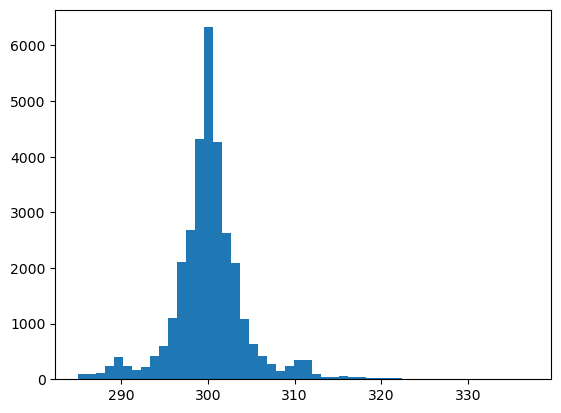

In [87]:
res = s.mask((s>s.quantile(0.99))|(s<s.quantile(0.01)))
_ = plt.hist(res, bins=50)

#### 3.
(a)

In [88]:
res = df.Radiation.rolling('6H').corr(df.Temperature)
res.tail(3)

Datetime
2016-12-31 23:45:04    0.328574
2016-12-31 23:50:03    0.261883
2016-12-31 23:55:01    0.262406
dtype: float64

(b)

In [89]:
res = df.Temperature.resample('6H', origin='03:00:00').mean()
res.head(3)

Datetime
2016-08-31 21:00:00    51.218750
2016-09-01 03:00:00    50.033333
2016-09-01 09:00:00    59.379310
Freq: 6H, Name: Temperature, dtype: float64

(c)

In [90]:
my_dt = df.index.shift(freq='-6H')
int_loc = [df.index.get_indexer([i], method='nearest') for i in my_dt]
int_loc = np.array(int_loc).reshape(-1)
res = df.Radiation.iloc[int_loc]
res.index = df.index
res.tail(3)

Datetime
2016-12-31 23:45:04    9.33
2016-12-31 23:50:03    8.49
2016-12-31 23:55:01    5.84
Name: Radiation, dtype: float64

另一种方法 `merge_asof()`

In [91]:
target = pd.DataFrame(
    {
        "Time": df.index.shift(freq='-6H'),
        "Datetime": df.index,
    }
)
res = pd.merge_asof(
    target,
    df.reset_index().rename(columns={"Datetime": "Time"}),
    left_on="Time",
    right_on="Time",
    direction="nearest"
).set_index("Datetime").Radiation
res.tail(3)

Datetime
2016-12-31 23:45:04    9.33
2016-12-31 23:50:03    8.49
2016-12-31 23:55:01    5.84
Name: Radiation, dtype: float64

### Ex2：水果销量数据集
#### 1.
(a)

In [92]:
df = pd.read_csv('../data/fruit.csv')
df.Date = pd.to_datetime(df.Date)
df_grape = df.query("Fruit == 'Grape'")
res = df_grape.groupby([np.where(df_grape.Date.dt.day<=15,'First', 'Second'),
                        df_grape.Date.dt.month])['Sale'].mean().to_frame().unstack(0).droplevel(0,axis=1)
res = (res.First/res.Second).rename_axis('Month')
res.head()

Month
1    1.174998
2    0.968890
3    0.951351
4    1.020797
5    0.931061
dtype: float64

(b)

In [93]:
df[df.Date.dt.is_month_end].query("Fruit == 'Pear'").groupby('Date').Sale.sum().head()

Date
2019-01-31    847
2019-02-28    774
2019-03-31    761
2019-04-30    648
2019-05-31    616
Name: Sale, dtype: int64

(c)

In [94]:
df[df.Date.isin(pd.date_range('20190101', '20191231',freq='BM'))].query("Fruit == 'Pear'").groupby('Date').Sale.mean().head()

Date
2019-01-31    60.500000
2019-02-28    59.538462
2019-03-29    56.666667
2019-04-30    64.800000
2019-05-31    61.600000
Name: Sale, dtype: float64

(d)

In [95]:
target_dt = df.drop_duplicates().groupby(df.Date.drop_duplicates().dt.month)['Date'].nlargest(5).reset_index(drop=True)
res = df.set_index('Date').loc[target_dt].reset_index().query("Fruit == 'Apple'")
res = res.groupby(res.Date.dt.month)['Sale'].mean().rename_axis('Month')
res.head()

Month
1    65.313725
2    54.061538
3    59.325581
4    65.795455
5    57.465116
Name: Sale, dtype: float64

#### 2.

In [96]:
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
week_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sum']
group1 = df.Date.dt.month_name().astype('category').cat.reorder_categories(month_order, ordered=True)
group2 = df.Fruit
group3 = df.Date.dt.dayofweek.replace(dict(zip(range(7),week_order))).astype('category').cat.reorder_categories(week_order, ordered=True)
res = df.groupby([group1, group2,group3])['Sale'].count().to_frame().unstack(0).droplevel(0,axis=1)
res.head()

Date        January  February  March  April  May  June  July  August  \
Fruit Date                                                             
Apple Mon        46        43     43     47   43    40    41      38   
      Tue        50        40     44     52   46    39    50      42   
      Wed        50        47     37     43   39    39    58      43   
      Thu        45        35     31     47   58    33    52      44   
      Fri        32        33     52     31   46    38    37      48   

Date        September  October  November  December  
Fruit Date                                          
Apple Mon          59       42        39        45  
      Tue          40       57        47        47  
      Wed          35       46        47        38  
      Thu          36       63        37        40  
      Fri          34       37        46        41

#### 3.

In [97]:
df_apple = df[(df.Fruit=='Apple')&(~df.Date.dt.dayofweek.isin([5,6]))]
s = pd.Series(df_apple.Sale.values,index=df_apple.Date).groupby('Date').sum()
res = s.rolling('10D').mean().reindex(pd.date_range('20190101','20191231')).fillna(method='ffill')
res.head()

2019-01-01    189.000000
2019-01-02    335.500000
2019-01-03    520.333333
2019-01-04    527.750000
2019-01-05    527.750000
Freq: D, dtype: float64